In [4]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import aic, bic
import statsmodels.api as sm
import os

class MultiLinear:
    
    def __init__(self):
        self.path = os.getcwd() 
        self.path =os.path.abspath(os.path.join(self.path, "..", ".."))
        self.imagePath = os.path.join(f'{self.path}\\graph_image')

    def make_dir(self):
        if not os.path.exists(self.imagePath):
            os.makedirs(os.path.join(f'{self.path}\\graph_image'))
        else:
            print('이미 존재합니다.')

    def load_dataset(self):
        dataset = pd.read_csv(f'{self.path}//filtered_data//체중감량 예측모델 데이터셋.csv')
        dataset = dataset.drop('Date_1', axis = 1)
        dataset = dataset.drop('ProgressNote_1', axis = 1)
        medians = dataset.median()
        dataset.loc[dataset['Pulse_1'] == 0, 'Pulse_1'] = 83
        dataset.loc[dataset['MaxVital_1'] > 1000, 'MaxVital_1'] = medians['MaxVital_1']
        dataset.loc[dataset['MinVital_1'] < 20, 'MinVital_1'] = medians['MinVital_1']
        dataset.loc[dataset['WHR_1'] > 3, 'WHR_1'] = medians['WHR_1']
        dataset['MaxVital_1'].fillna(medians['MaxVital_1'], inplace =True)
        dataset['MinVital_1'].fillna(medians['MinVital_1'], inplace =True)
        dataset['Pulse_1'].fillna(83, inplace =True)
        self.dataset = dataset[dataset['BMI_1']<50]
        return self.dataset

    def standardized(self,X,y):
        from sklearn.preprocessing import StandardScaler
        
        # X 데이터 표준화
        scaler = StandardScaler()
        X_standardized = scaler.fit_transform(X)
        
        # y 데이터 표준화
        y_mean = y.mean()
        y_std = y.std()
        y_standardized = (y - y_mean) / y_std

        return X_standardized, y_std

    def split_Xy(self, dataset, col):
        X = dataset.iloc[:, :32]  # 특성
        y = dataset[col]
        return X ,y

    def lasso(self, X, y, alpha =0.1, random_state = 1111):
        from sklearn.linear_model import Lasso
        from sklearn.metrics import mean_squared_error
        
        # Lasso 회귀 모델
        lasso = Lasso(alpha=alpha)  # alpha 값은 정규화 강도를 조절합니다.
        lasso.fit(X, y)
        lasso_coef = lasso.coef_
        
        selected_features = X.columns[lasso_coef != 0]
        print("The Number of Selected Features by Lasso:", len(selected_features))
        print("Selected Features by Lasso:", selected_features)
        return selected_features

    def calculate_metrics(self, X_train, y_train, X_test, y_test, selected_features):
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        model = sm.OLS(y_train, sm.add_constant(X_train_subset)).fit()
        y_pred = model.predict(sm.add_constant(X_test_subset))
        
        # Adjusted R^2 계산
        adj_r2 = 1 - (1 - model.rsquared) * (len(y_test) - 1) / (len(y_test) - X_test_subset.shape[1] - 1)
        
        # AIC 및 BIC 계산
        aic_value = model.aic
        bic_value = model.bic
        
        return adj_r2, aic_value, bic_value
    
    def get_feature_combinations(self, X_train):
        feature_combinations = []
        num_features = X_train.shape[1]
        
        for r in range(2, num_features + 1):
            combinations = itertools.combinations(X_train.columns, r)
            feature_combinations.extend(combinations)
        
        return feature_combinations

    def find_best_feature_set(self, X_train, y_train, image_name = 'XXX', random_state = 1111):
        if X_train.shape[0] != y_train.shape[0]:
            print('X, y shape is not same')
            return
            
        # 변수 조합 생성
        feature_combinations = self.get_feature_combinations(X_train)
        
        # 결과 저장을 위한 리스트
        results = []
        
        # 각 조합에 대해 메트릭 계산
        for features in feature_combinations:
            adj_r2, aic_value, bic_value = self.calculate_metrics(X_train, y_train, X_test, y_test, list(features))
            results.append({
                'Features': features,
                'Adjusted R^2': adj_r2,
                'AIC': aic_value,
                'BIC': bic_value
            })
            #print(f'Features: {features}\nAdjusted R^2: {adj_r2}, AIC: {aic_value}, BIC: {bic_value}\n')
        
        # DataFrame으로 변환
        results_df = pd.DataFrame(results)
        
        # 최적의 조합 찾기
        best_adj_r2 = results_df.loc[results_df['Adjusted R^2'].idxmax()]
        best_aic = results_df.loc[results_df['AIC'].idxmin()]
        best_bic = results_df.loc[results_df['BIC'].idxmin()]
        
        print("Best Adjusted R^2 Combination:", best_adj_r2)
        print("Best AIC Combination:", best_aic)
        print("Best BIC Combination:", best_bic)
        
        # 시각화
        plt.figure(figsize=(18, 6))
        
        # Adjusted R^2
        plt.subplot(1, 3, 1)
        sns.scatterplot(x=results_df['Features'].apply(lambda x: len(x)), y=results_df['Adjusted R^2'])
        plt.title('Adjusted R^2 vs Number of Features')
        plt.xlabel('Number of Features')
        plt.ylabel('Adjusted R^2')
        
        # AIC
        plt.subplot(1, 3, 2)
        sns.scatterplot(x=results_df['Features'].apply(lambda x: len(x)), y=results_df['AIC'])
        plt.title('AIC vs Number of Features')
        plt.xlabel('Number of Features')
        plt.ylabel('AIC')
        
        # BIC
        plt.subplot(1, 3, 3)
        sns.scatterplot(x=results_df['Features'].apply(lambda x: len(x)), y=results_df['BIC'])
        plt.title('BIC vs Number of Features')
        plt.xlabel('Number of Features')
        plt.ylabel('BIC')
        
        plt.tight_layout()
        plt.savefig(f'{self.imagePath}\\{image_name} Find Best Feature Set.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        #결과 출력
        print("Best R^2 Combination:", best_adj_r2['Features'])
        print("Best AIC Combination:", best_aic['Features'])
        print("Best BIC Combination:", best_bic['Features'])

        return list(best_adj_r2['Features']), list(best_aic['Features']), list(best_bic['Features'])

    def t_test(self, X_train, y_train, image_name ='XXX'):
        import statsmodels.api as sm
        import matplotlib.pyplot as plt
        import pandas as pd
        import seaborn as sns
    
        # 기능 세트 1에 대한 모델
        X_train_set1 = X_train
        X_train_set1_const = sm.add_constant(X_train_set1)  # 상수항 추가
        model_set1 = sm.OLS(y_train, X_train_set1_const).fit()
        
        # 모델 요약 출력
        print(f"Model Summary for {image_name}:")
        print(model_set1.summary())

        # 변수들의 유의성 시각화
        def plot_pvalues(model, image_name):
            pvalues = model.pvalues[1:]  # 상수항 제외
            pvalues = pvalues.sort_values(ascending=True)
            plt.figure(figsize=(10, 5))
            sns.barplot(x=pvalues.index, y=pvalues.values)
            plt.axhline(0.05, color='red', linestyle='--')
            plt.title(image_name)
            plt.ylabel('p-value')
            plt.xticks(rotation=45)
            plt.savefig(f'{self.imagePath}\\{image_name} Variable Significance (p-values).png', dpi=300, bbox_inches='tight')
            plt.show()
        
        # Feature Set 1의 변수 유의성 시각화
        plot_pvalues(model_set1, image_name)
        return model_set1

    def residual_test(self, X_train, y_train, image_name='XXX'):
        import statsmodels.api as sm
        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np

        # 모델에 상수항 추가
        X_train_final_const = sm.add_constant(X_train)
        
        # 다중선형회귀 모델 학습
        model_final = sm.OLS(y_train, X_train_final_const).fit()
        
        # 잔차 계산
        residuals = model_final.resid
        
        # 준스튜던트화 잔차 계산
        influence = model_final.get_influence()
        studentized_residuals = influence.resid_studentized_internal
        
        # 잔차 분석
        def plot_residuals_analysis(model, residuals, studentized_residuals, image_name = 'XXX'):
            # 히스토그램
            plt.figure(figsize=(14, 6))
        
            plt.subplot(1, 3, 1)
            sns.histplot(residuals, kde=True, bins=30)
            plt.title('Residuals Histogram')
            plt.xlabel('Residuals')
            plt.ylabel('Frequency')
        
            # Q-Q 플롯 (정규성 검증)
            plt.subplot(1, 3, 2)
            sm.qqplot(residuals, line='s', ax=plt.gca())
            plt.title('Q-Q Plot')
        
            # 준스튜던트화 잔차 대 예측값 플롯
            plt.subplot(1, 3, 3)
            plt.scatter(model.fittedvalues, studentized_residuals)
            plt.axhline(y=0, color='red', linestyle='--')
            plt.title('Studentized Residuals vs Fitted Values')
            plt.xlabel('Fitted Values')
            plt.ylabel('Studentized Residuals')
        
            plt.tight_layout()
            plt.savefig(f'{self.imagePath}\\{image_name} residual test.png', dpi=300, bbox_inches='tight')
            plt.show()
        
        # 잔차 분석 함수 호출
        plot_residuals_analysis(model_final, residuals, studentized_residuals, image_name)
        print("Residuals Summary:")
        print(residuals.describe())
        durbin_watson = sm.stats.stattools.durbin_watson(residuals)
        print(f"Durbin-Watson Statistic: {durbin_watson}")

        # 이상치 인덱스 선택 (절대값이 4 이상인 경우)
        outliers_index = np.where(np.abs(studentized_residuals) >= 4)[0]
        print(f'outliers index: {outliers_index}')
        X_filtered = X_train.drop(index=X_train.index[outliers_index])
        y_filtered = y_train.drop(index=y_train.index[outliers_index])
        
        return X_filtered, y_filtered

    def calculate_correlations(self, X, y):
        # X와 y를 하나의 데이터프레임으로 합침
        data = X.copy()
        data['target'] = y
        
        # 상관계수 계산
        correlations = data.corr()['target'].sort_values(ascending=False)
        
        # 상관계수 출력
        print("Correlations with Target:")
        print(correlations)
        
        # 시각화
        plt.figure(figsize=(10, 8))
        sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation Matrix')
        plt.show()

        return correlations

    def VIF(self, X):
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        
        # 상수항 추가
        X_const = sm.add_constant(X_final)
        
        # VIF 계산
        vif_data = pd.DataFrame()
        vif_data['Variable'] = X_const.columns
        vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
        
        print(vif_data)

    def model(self, X, y):
        # 모델에 상수항 추가
        X_train_final_const = sm.add_constant(X)
        
        # 다중선형회귀 모델 학습
        model_final = sm.OLS(y, X_train_final_const).fit()
        
        # 잔차 계산
        residuals = model_final.resid
        plt.scatter(model.fittedvalues, residuals)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title('Studentized Residuals vs Fitted Values')
        plt.xlabel('Fitted Values')
        plt.ylabel('Studentized Residuals')
        return model_final

    def model_test(self, model, X_test, y_test):
        X_test_const = sm.add_constant(X_test)
        # 모델 예측
        y_pred = model.predict(X_test_const)
        
        # RMSE 계산
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"RMSE: {rmse}")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(y_pred,y_test)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # 대각선 y=x
        plt.xlabel('Predicted Values')
        plt.ylabel('Actual Values')
        plt.title('Predicted vs Actual')
    

        plt.subplot(1, 2, 2)
        plt.scatter(y_pred, y_test-y_pred)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Actual Values')
        plt.title('Predicted vs residual')
        
        
    def predict(self, model, x):
        import numpy as np
        y_pred = model.predict([x])
        # 잔차 (Residuals)
        residuals = model.predict(model._data_X) - model._data_y
        # 잔차의 표준편차 계산
        residual_std = np.std(residuals)
        return y_pred[0], residual_std

In [5]:
ML = MultiLinear()
dataset = ML.load_dataset()

In [7]:
target = 'Weight_After'

In [8]:
X, y = ML.split_Xy(dataset, target)

In [10]:
pip install pytorch-tabnet

   ---------------------------------------- 0.0/44.5 kB ? eta -:--:--
   ---------------------------------------- 44.5/44.5 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_tabnet.tab_model import TabNetRegressor

# 데이터 준비
# X: 입력 데이터, y: 타겟 데이터
X = X.values
y = y.values.reshape(-1, 1)

C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 41.94496|  0:00:00s
epoch 1  | loss: 22.72031|  0:00:00s
epoch 2  | loss: 12.57217|  0:00:01s
epoch 3  | loss: 10.45762|  0:00:01s
epoch 4  | loss: 9.24101 |  0:00:01s
epoch 5  | loss: 9.07194 |  0:00:02s
epoch 6  | loss: 8.32017 |  0:00:02s
epoch 7  | loss: 8.04986 |  0:00:02s
epoch 8  | loss: 8.1531  |  0:00:02s
epoch 9  | loss: 7.96523 |  0:00:03s
epoch 10 | loss: 7.88698 |  0:00:03s
epoch 11 | loss: 7.4263  |  0:00:03s
epoch 12 | loss: 7.5092  |  0:00:04s
epoch 13 | loss: 7.55973 |  0:00:04s
epoch 14 | loss: 7.54567 |  0:00:04s
epoch 15 | loss: 7.82384 |  0:00:05s
epoch 16 | loss: 7.40909 |  0:00:05s
epoch 17 | loss: 7.54223 |  0:00:05s
epoch 18 | loss: 7.3429  |  0:00:05s
epoch 19 | loss: 7.23542 |  0:00:06s
epoch 20 | loss: 7.44246 |  0:00:06s
epoch 21 | loss: 7.60214 |  0:00:06s
epoch 22 | loss: 7.82035 |  0:00:07s
epoch 23 | loss: 7.68367 |  0:00:07s
epoch 24 | loss: 7.52005 |  0:00:07s
epoch 25 | loss: 7.52591 |  0:00:08s
epoch 26 | loss: 7.46319 |  0:00:08s
e

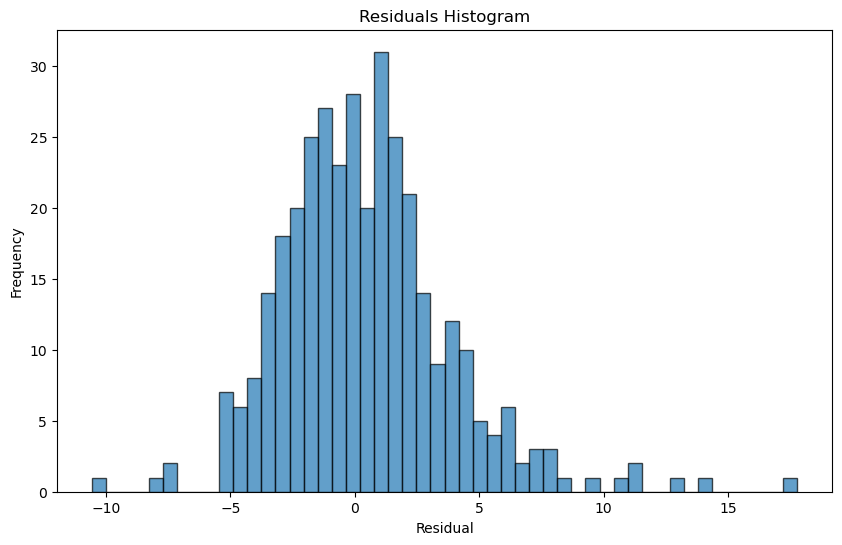

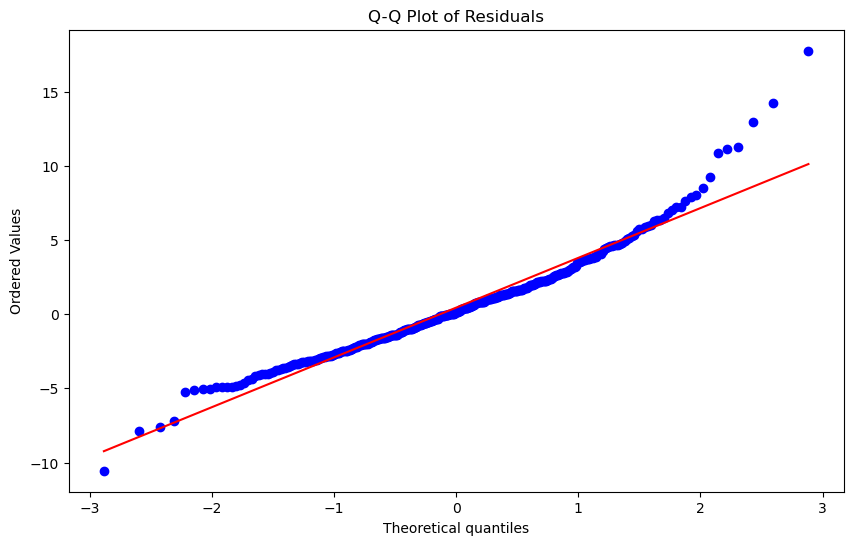

In [23]:
X, y = ML.split_Xy(dataset, target)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pytorch_tabnet.tab_model import TabNetRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats

# 데이터 준비
# X: 입력 데이터, y: 타겟 데이터
X = X.values
y = y.values.reshape(-1, 1)

# 데이터 분할 (80% 훈련 데이터, 20% 테스트 데이터)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TabNet 모델 정의
model = TabNetRegressor(
    n_d=8,  # Number of decision steps
    n_a=8,  # Number of attention steps
    n_steps=3,  # Number of steps in the network
    gamma=1.3,  # L1 regularization term
    cat_emb_dim=1,  # Dimension of embedding for categorical features
    lambda_sparse=1e-4  # Sparsity regularization term
)

# 모델 학습
model.fit(
    X_train=X_train,
    y_train=y_train,
    max_epochs=100,
    patience=50,  # Increased patience to avoid premature stopping
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# 예측
y_pred = model.predict(X_test)

# MSE 계산
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")

# 잔차 분석
residuals = y_test - y_pred

# 잔차 시각화 (히스토그램)
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Residuals Histogram")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# 잔차의 분포를 확인하기 위한 Q-Q 플롯
plt.figure(figsize=(10, 6))

stats.probplot(residuals.flatten(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 42.37706|  0:00:00s
epoch 1  | loss: 21.21207|  0:00:00s
epoch 2  | loss: 13.4899 |  0:00:00s
epoch 3  | loss: 10.74711|  0:00:01s
epoch 4  | loss: 9.4955  |  0:00:01s
epoch 5  | loss: 8.99768 |  0:00:01s
epoch 6  | loss: 8.51082 |  0:00:02s
epoch 7  | loss: 8.42171 |  0:00:02s
epoch 8  | loss: 8.24878 |  0:00:02s
epoch 9  | loss: 8.0934  |  0:00:02s
epoch 10 | loss: 7.88411 |  0:00:03s
epoch 11 | loss: 7.61301 |  0:00:03s
epoch 12 | loss: 7.63015 |  0:00:03s
epoch 13 | loss: 7.48907 |  0:00:04s
epoch 14 | loss: 7.29891 |  0:00:04s
epoch 15 | loss: 7.15279 |  0:00:04s
epoch 16 | loss: 7.25211 |  0:00:04s
epoch 17 | loss: 7.0992  |  0:00:05s
epoch 18 | loss: 7.14411 |  0:00:05s
epoch 19 | loss: 7.1132  |  0:00:05s
epoch 20 | loss: 7.11503 |  0:00:05s
epoch 21 | loss: 7.13534 |  0:00:06s
epoch 22 | loss: 6.96745 |  0:00:06s
epoch 23 | loss: 7.09731 |  0:00:06s
epoch 24 | loss: 6.86725 |  0:00:06s
epoch 25 | loss: 7.28674 |  0:00:07s
epoch 26 | loss: 7.11266 |  0:00:07s
e

C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 44.55702|  0:00:00s
epoch 1  | loss: 24.57427|  0:00:00s
epoch 2  | loss: 14.21854|  0:00:00s
epoch 3  | loss: 11.50015|  0:00:01s
epoch 4  | loss: 10.88789|  0:00:01s
epoch 5  | loss: 9.78642 |  0:00:01s
epoch 6  | loss: 9.77112 |  0:00:02s
epoch 7  | loss: 9.28992 |  0:00:02s
epoch 8  | loss: 9.22212 |  0:00:02s
epoch 9  | loss: 8.89666 |  0:00:03s
epoch 10 | loss: 9.24781 |  0:00:03s
epoch 11 | loss: 8.99273 |  0:00:03s
epoch 12 | loss: 9.33468 |  0:00:04s
epoch 13 | loss: 9.17266 |  0:00:04s
epoch 14 | loss: 8.84803 |  0:00:04s
epoch 15 | loss: 8.89447 |  0:00:05s
epoch 16 | loss: 8.78302 |  0:00:05s
epoch 17 | loss: 8.47089 |  0:00:05s
epoch 18 | loss: 8.85322 |  0:00:06s
epoch 19 | loss: 8.72882 |  0:00:06s
epoch 20 | loss: 8.43808 |  0:00:06s
epoch 21 | loss: 8.70464 |  0:00:07s
epoch 22 | loss: 8.7002  |  0:00:07s
epoch 23 | loss: 8.47498 |  0:00:07s
epoch 24 | loss: 8.65975 |  0:00:08s
epoch 25 | loss: 8.86024 |  0:00:08s
epoch 26 | loss: 8.91791 |  0:00:08s
e

C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 44.56786|  0:00:00s
epoch 1  | loss: 23.32446|  0:00:00s
epoch 2  | loss: 13.805  |  0:00:01s
epoch 3  | loss: 11.72631|  0:00:01s
epoch 4  | loss: 11.27878|  0:00:01s
epoch 5  | loss: 9.64239 |  0:00:01s
epoch 6  | loss: 9.56578 |  0:00:02s
epoch 7  | loss: 9.36307 |  0:00:02s
epoch 8  | loss: 9.13252 |  0:00:02s
epoch 9  | loss: 9.4407  |  0:00:03s
epoch 10 | loss: 9.26888 |  0:00:03s
epoch 11 | loss: 9.08764 |  0:00:03s
epoch 12 | loss: 8.55115 |  0:00:04s
epoch 13 | loss: 8.45056 |  0:00:04s
epoch 14 | loss: 8.23401 |  0:00:04s
epoch 15 | loss: 8.36183 |  0:00:05s
epoch 16 | loss: 8.43888 |  0:00:05s
epoch 17 | loss: 8.33277 |  0:00:05s
epoch 18 | loss: 8.43841 |  0:00:06s
epoch 19 | loss: 8.34312 |  0:00:06s
epoch 20 | loss: 8.37649 |  0:00:06s
epoch 21 | loss: 8.15663 |  0:00:07s
epoch 22 | loss: 8.25809 |  0:00:07s
epoch 23 | loss: 7.92149 |  0:00:07s
epoch 24 | loss: 8.13455 |  0:00:08s
epoch 25 | loss: 8.0354  |  0:00:08s
epoch 26 | loss: 8.21132 |  0:00:08s
e

C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 44.31688|  0:00:00s
epoch 1  | loss: 23.70118|  0:00:00s
epoch 2  | loss: 14.19997|  0:00:00s
epoch 3  | loss: 10.70536|  0:00:01s
epoch 4  | loss: 9.72978 |  0:00:01s
epoch 5  | loss: 9.22926 |  0:00:01s
epoch 6  | loss: 8.84922 |  0:00:02s
epoch 7  | loss: 8.74395 |  0:00:02s
epoch 8  | loss: 8.60044 |  0:00:02s
epoch 9  | loss: 8.56076 |  0:00:03s
epoch 10 | loss: 8.60024 |  0:00:03s
epoch 11 | loss: 8.45989 |  0:00:03s
epoch 12 | loss: 8.47341 |  0:00:04s
epoch 13 | loss: 8.31518 |  0:00:04s
epoch 14 | loss: 8.34449 |  0:00:04s
epoch 15 | loss: 8.34601 |  0:00:05s
epoch 16 | loss: 8.10285 |  0:00:05s
epoch 17 | loss: 7.98709 |  0:00:05s
epoch 18 | loss: 8.02586 |  0:00:05s
epoch 19 | loss: 7.87659 |  0:00:06s
epoch 20 | loss: 7.81585 |  0:00:06s
epoch 21 | loss: 7.79655 |  0:00:06s
epoch 22 | loss: 7.74695 |  0:00:07s
epoch 23 | loss: 7.96824 |  0:00:07s
epoch 24 | loss: 8.1916  |  0:00:07s
epoch 25 | loss: 7.92482 |  0:00:08s
epoch 26 | loss: 7.8508  |  0:00:08s
e

C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 43.52488|  0:00:00s
epoch 1  | loss: 24.01059|  0:00:00s
epoch 2  | loss: 14.42707|  0:00:00s
epoch 3  | loss: 12.2862 |  0:00:00s
epoch 4  | loss: 10.8979 |  0:00:01s
epoch 5  | loss: 10.17034|  0:00:01s
epoch 6  | loss: 9.60681 |  0:00:01s
epoch 7  | loss: 9.46096 |  0:00:01s
epoch 8  | loss: 9.06644 |  0:00:02s
epoch 9  | loss: 9.10255 |  0:00:02s
epoch 10 | loss: 9.26001 |  0:00:02s
epoch 11 | loss: 9.03894 |  0:00:02s
epoch 12 | loss: 8.78308 |  0:00:02s
epoch 13 | loss: 8.65427 |  0:00:03s
epoch 14 | loss: 8.83323 |  0:00:03s
epoch 15 | loss: 8.66892 |  0:00:03s
epoch 16 | loss: 8.56797 |  0:00:03s
epoch 17 | loss: 8.56754 |  0:00:04s
epoch 18 | loss: 8.67991 |  0:00:04s
epoch 19 | loss: 8.54235 |  0:00:04s
epoch 20 | loss: 8.49457 |  0:00:04s
epoch 21 | loss: 8.46976 |  0:00:05s
epoch 22 | loss: 8.80321 |  0:00:05s
epoch 23 | loss: 8.53638 |  0:00:05s
epoch 24 | loss: 8.40331 |  0:00:05s
epoch 25 | loss: 8.5955  |  0:00:05s
epoch 26 | loss: 8.75544 |  0:00:06s
e

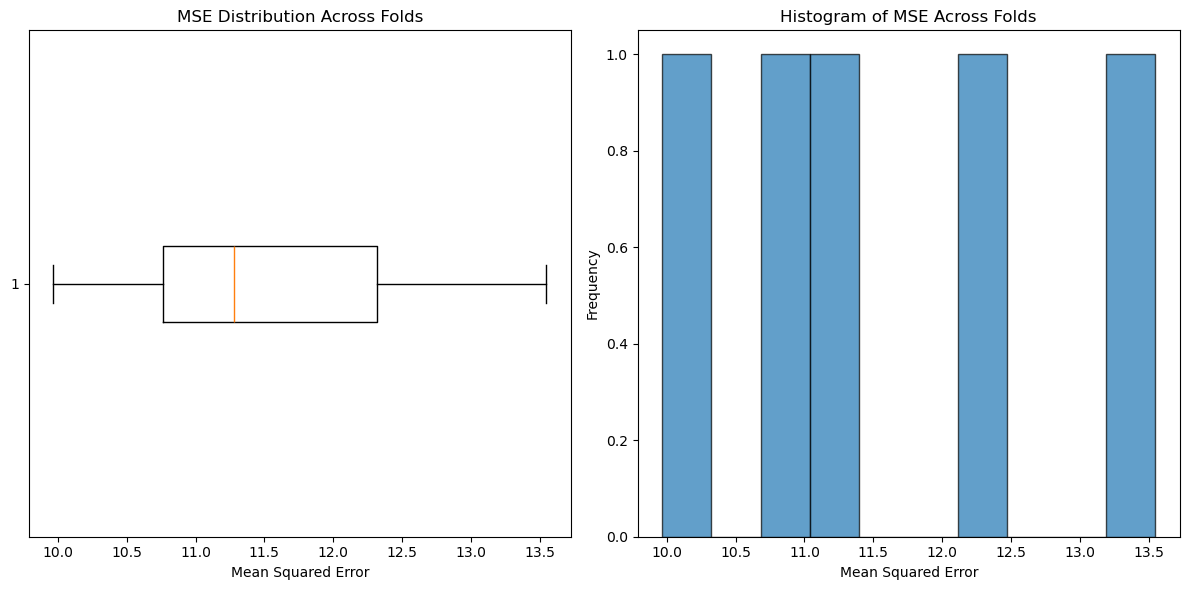

C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 43.52488|  0:00:00s
epoch 1  | loss: 24.01059|  0:00:00s
epoch 2  | loss: 14.42707|  0:00:00s
epoch 3  | loss: 12.2862 |  0:00:00s
epoch 4  | loss: 10.8979 |  0:00:01s
epoch 5  | loss: 10.17034|  0:00:01s
epoch 6  | loss: 9.60681 |  0:00:01s
epoch 7  | loss: 9.46096 |  0:00:01s
epoch 8  | loss: 9.06644 |  0:00:02s
epoch 9  | loss: 9.10255 |  0:00:02s
epoch 10 | loss: 9.26001 |  0:00:02s
epoch 11 | loss: 9.03894 |  0:00:02s
epoch 12 | loss: 8.78308 |  0:00:03s
epoch 13 | loss: 8.65427 |  0:00:03s
epoch 14 | loss: 8.83323 |  0:00:03s
epoch 15 | loss: 8.66892 |  0:00:03s
epoch 16 | loss: 8.56797 |  0:00:04s
epoch 17 | loss: 8.56754 |  0:00:04s
epoch 18 | loss: 8.67991 |  0:00:04s
epoch 19 | loss: 8.54235 |  0:00:04s
epoch 20 | loss: 8.49457 |  0:00:04s
epoch 21 | loss: 8.46976 |  0:00:05s
epoch 22 | loss: 8.80321 |  0:00:05s
epoch 23 | loss: 8.53638 |  0:00:05s
epoch 24 | loss: 8.40331 |  0:00:05s
epoch 25 | loss: 8.5955  |  0:00:06s
epoch 26 | loss: 8.75544 |  0:00:06s
e

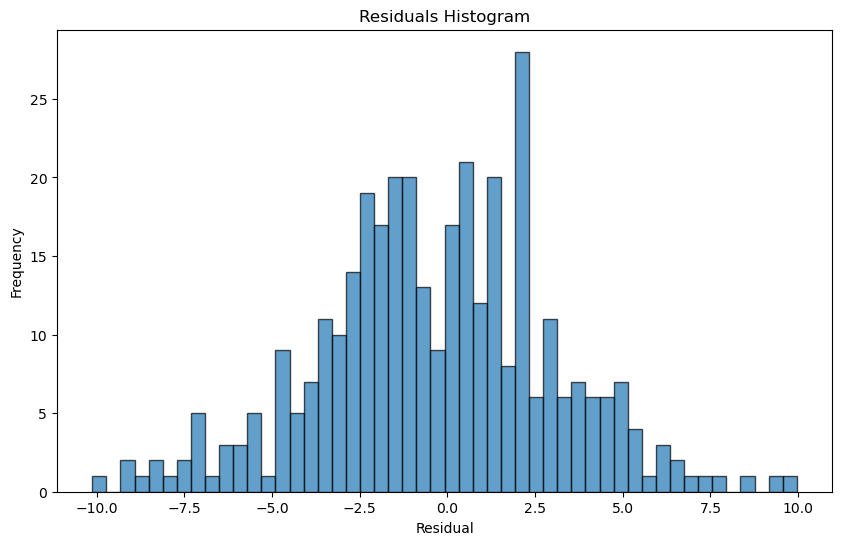

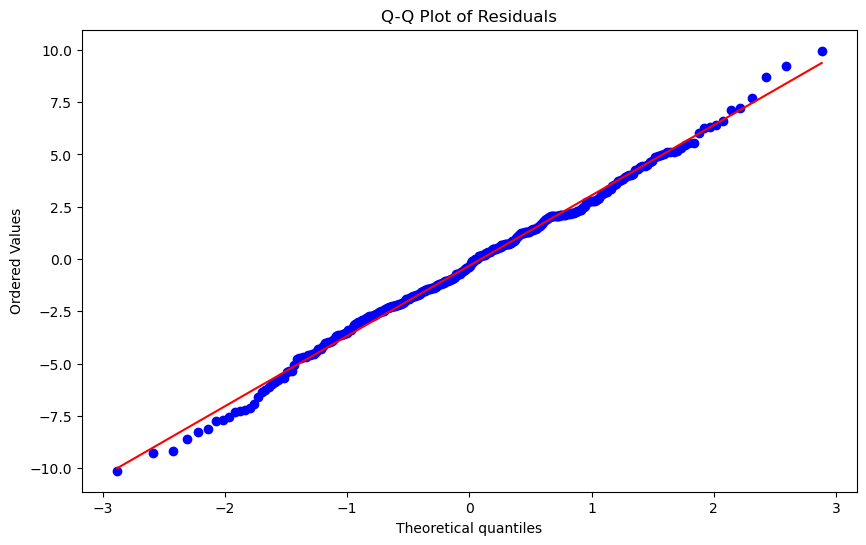

In [30]:
X, y = ML.split_Xy(dataset, target)
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from pytorch_tabnet.tab_model import TabNetRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats

# 데이터 준비
# X: 입력 데이터, y: 타겟 데이터
X = X.values
y = y.values.reshape(-1, 1)

# K-Fold 교차 검정 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

mse_list = []

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # TabNet 모델 정의
    model = TabNetRegressor(
        n_d=8,
        n_a=8,
        n_steps=3,
        gamma=1.3,
        cat_emb_dim=1,
        lambda_sparse=1e-4
    )
    
    # 모델 학습
    model.fit(
        X_train=X_train,
        y_train=y_train,
        max_epochs=10000,
        patience=50,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )
    
    # 예측
    y_pred = model.predict(X_test)
    
    # MSE 계산
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)
    print(f"Fold {fold+1} MSE: {mse}")

# 평균 MSE와 표준편차 계산
mean_mse = np.mean(mse_list)
std_mse = np.std(mse_list)
print(f"Mean MSE: {mean_mse}")
print(f"Standard Deviation of MSE: {std_mse}")

# 결과 시각화
plt.figure(figsize=(12, 6))

# MSE 박스플롯
plt.subplot(1, 2, 1)
plt.boxplot(mse_list, vert=False)
plt.title("MSE Distribution Across Folds")
plt.xlabel("Mean Squared Error")

# MSE 히스토그램
plt.subplot(1, 2, 2)
plt.hist(mse_list, bins=10, edgecolor='k', alpha=0.7)
plt.title("Histogram of MSE Across Folds")
plt.xlabel("Mean Squared Error")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# 잔차 분석을 위한 최종 모델 (마지막 폴드 사용)
train_index, test_index = list(kf.split(X))[-1]  # 마지막 폴드 인덱스 추출
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

model = TabNetRegressor(
    n_d=8,
    n_a=8,
    n_steps=3,
    gamma=1.3,
    cat_emb_dim=1,
    lambda_sparse=1e-4
)

model.fit(
    X_train=X_train,
    y_train=y_train,
    max_epochs=10000,
    patience=50,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# 예측
y_pred = model.predict(X_test)

# 잔차 분석
residuals = y_test - y_pred

# 잔차 시각화 (히스토그램)
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Residuals Histogram")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# 잔차의 분포를 확인하기 위한 Q-Q 플롯
plt.figure(figsize=(10, 6))
stats.probplot(residuals.flatten(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


In [32]:
import torch

torch.save(model.network.state_dict(), f'{ML.path}\\tabnet모델 cv버전')

Model saved to tabnet_model.pth


C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\howsr\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 42.25565|  0:00:00s
epoch 1  | loss: 23.63819|  0:00:00s
epoch 2  | loss: 13.55024|  0:00:01s
epoch 3  | loss: 10.48699|  0:00:01s
epoch 4  | loss: 9.29724 |  0:00:01s
epoch 5  | loss: 8.4073  |  0:00:02s
epoch 6  | loss: 7.91746 |  0:00:02s
epoch 7  | loss: 7.51724 |  0:00:02s
epoch 8  | loss: 7.72552 |  0:00:02s
epoch 9  | loss: 7.66514 |  0:00:03s
epoch 10 | loss: 7.30184 |  0:00:03s
epoch 11 | loss: 7.04357 |  0:00:03s
epoch 12 | loss: 6.96988 |  0:00:04s
epoch 13 | loss: 7.0259  |  0:00:04s
epoch 14 | loss: 6.70401 |  0:00:04s
epoch 15 | loss: 7.003   |  0:00:05s
epoch 16 | loss: 6.99099 |  0:00:05s
epoch 17 | loss: 6.70843 |  0:00:05s
epoch 18 | loss: 6.75733 |  0:00:05s
epoch 19 | loss: 6.88058 |  0:00:06s
epoch 20 | loss: 6.5302  |  0:00:06s
epoch 21 | loss: 6.49668 |  0:00:06s
epoch 22 | loss: 6.46127 |  0:00:07s
epoch 23 | loss: 6.12094 |  0:00:07s
epoch 24 | loss: 6.23898 |  0:00:07s
epoch 25 | loss: 6.13868 |  0:00:08s
epoch 26 | loss: 6.28771 |  0:00:08s
e

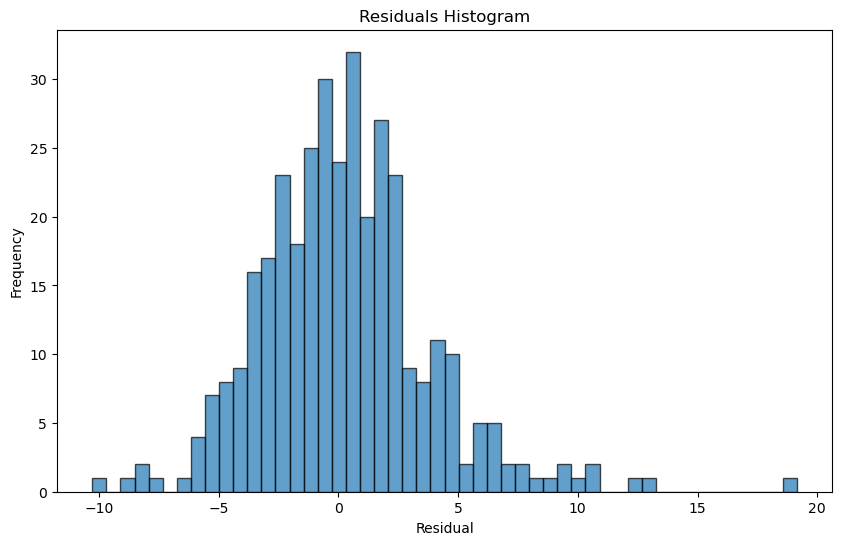

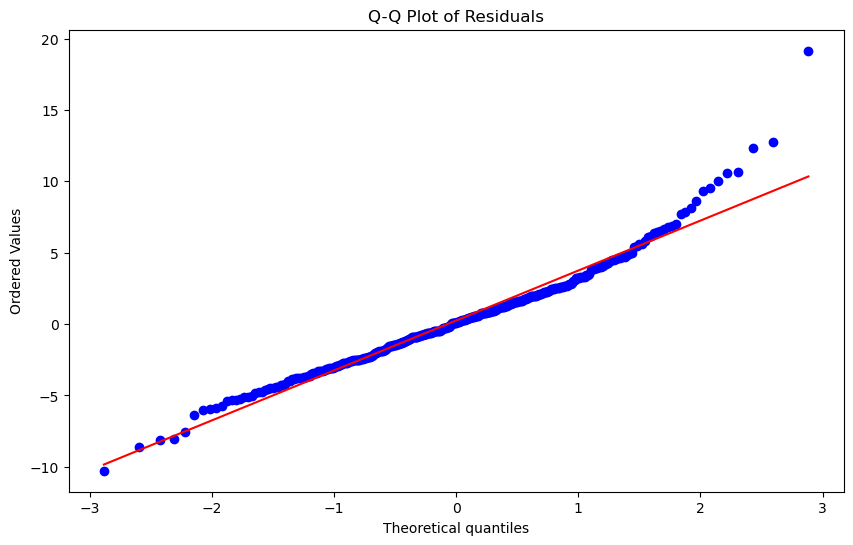

Model saved to tabnet_model_dropout.pth


In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pytorch_tabnet.tab_model import TabNetRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats

# 데이터 준비
X, y = ML.split_Xy(dataset, target)
X = X.values
y = y.values.reshape(-1, 1)

# 데이터셋 분할 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TabNet 모델 정의 (Dropout 기법을 위해 gamma 사용)
model = TabNetRegressor(
    n_d=8,
    n_a=8,
    n_steps=3,
    gamma=1.5,  # Dropout과 유사한 regularization 효과
    cat_emb_dim=1,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="entmax"  # "sparsemax" or "entmax"
)

# 모델 학습
model.fit(
    X_train=X_train,
    y_train=y_train,
    max_epochs=3000,
    patience=50,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# 테스트 데이터 예측
y_pred = model.predict(X_test)

# MSE 계산
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")

# 잔차 분석
residuals = y_test - y_pred

# 잔차 시각화 (히스토그램)
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Residuals Histogram")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# 잔차의 분포를 확인하기 위한 Q-Q 플롯
plt.figure(figsize=(10, 6))
stats.probplot(residuals.flatten(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# 모델 저장
import torch

model_path = "tabnet_model_dropout.pth"
torch.save(model.network.state_dict(), model_path)
print(f"Model saved to {model_path}")